Week3 : Histopathologic Cancer Detection<br>

In [1]:
import numpy as np 
import pandas as pd 


import os
from glob import glob
from random import shuffle
#import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers, Input
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#import tensorflow_io as tfio
from PIL import Image
#import cv2
print(tf.__version__)


2.15.0


file structure: <br>
```
./
├── ipynb/
│   ├── thisfile
│   ├── model
│   ├── ...
│   └── model
├── input/
│   ├── train/
│   ├── test/
│   └── csvfile
```

The Histopathologic Cancer Detection challenge tasks participants with developing an algorithm to identify metastatic cancer in small histopathology image patches. Each 96×96-pixel color image is extracted from lymph node tissue scans, and the goal is to predict whether the central 32×32 region contains one or more cancerous cells (label 1) or none (label 0). 
The dataset is a deduplicated version of the PatchCamelyon (PCam) benchmark. The training set comprises 220,025 TIFF images and the test set contains 57,458 TIFF images, each sized at 96×96 pixels with three color channels. Image files are organized into train/ and test/ directories, while train_labels.csv provides two columns—id (the unique filename without extension) and label (0 or 1)—for mapping each training image to its binary ground-truth label.

In [2]:
path = "../input/"
df = pd.read_csv(f"{path}train_labels.csv")
testpath = f"{path}test/"
trainpath = f"{path}train/"

print(df.head())
print(f"data has {df.shape[0]} row, and {df.shape[1]} columns")

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
data has 220025 row, and 2 columns


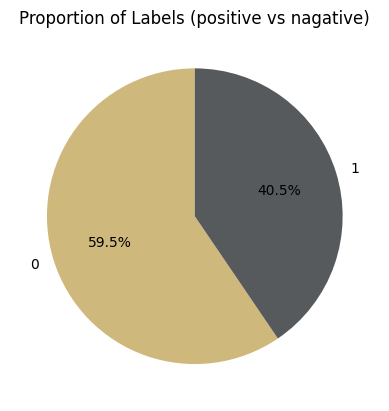

label
0    130908
1     89117
Name: count, dtype: int64


In [3]:
def pieratio(df):
    counts = df.value_counts()
    plt.pie(counts.values, 
            labels=counts.index,   
            autopct='%1.1f%%',     
            startangle=90,         
            colors=["#CFB87C", "#565A5C"])  
    
    plt.title("Proportion of Labels (positive vs nagative)")
    plt.show()
    print(counts)
pieratio(df["label"])

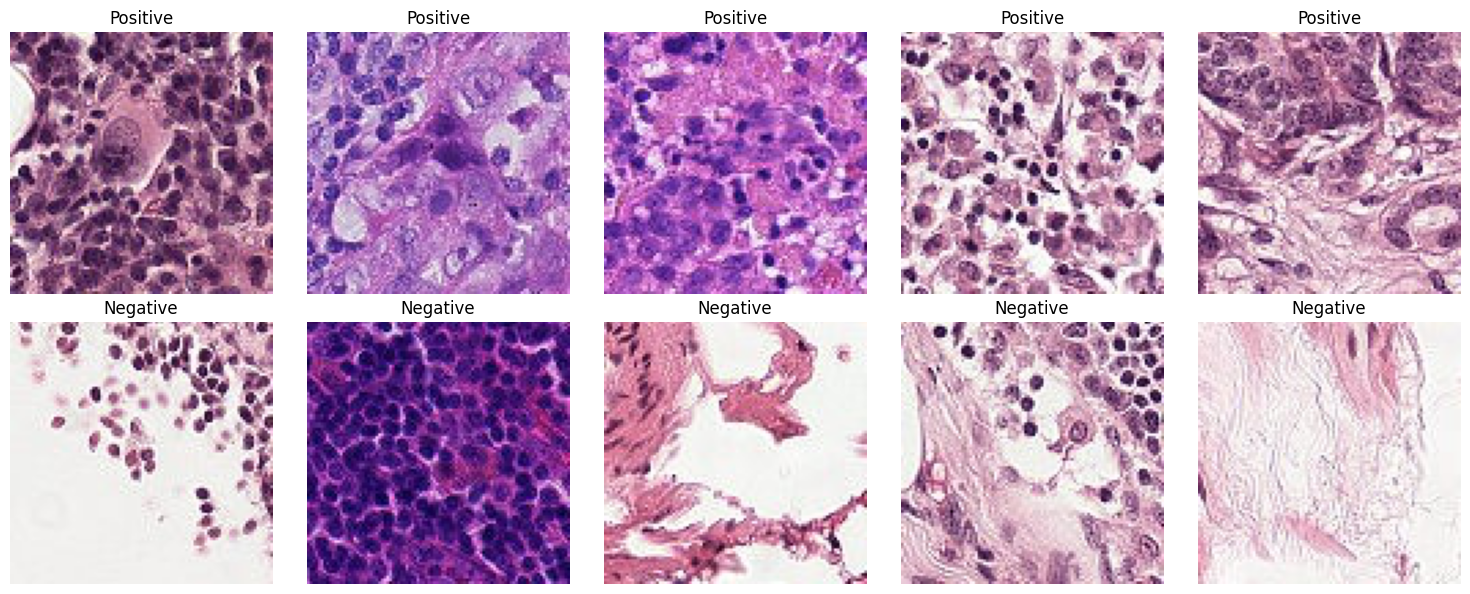

In [4]:
def show_samples(df, img_dir, img_size=96, n=5):

    pos_samples = df[df['label'] == 1].sample(n)
    neg_samples = df[df['label'] == 0].sample(n)

    fig, axes = plt.subplots(2, n, figsize=(3*n, 6))

    # Positive row
    for i, idx in enumerate(pos_samples['id'].values):
        img = Image.open(f"{img_dir}/{idx}.tif").resize((img_size, img_size))
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Positive")

    # Negative row
    for i, idx in enumerate(neg_samples['id'].values):
        img = Image.open(f"{img_dir}/{idx}.tif").resize((img_size, img_size))
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        axes[1, i].set_title("Negative")

    plt.tight_layout()
    plt.show()
show_samples(df, trainpath, img_size=96, n=5)

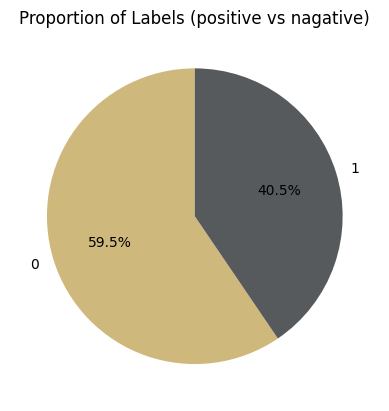

label
0    104726
1     71294
Name: count, dtype: int64


,id,label
68288,63569b2e82cbf30f0f0960b7ff4a5405c0b3a616,0
91672,67561688a8dbb71e87a6c6aece5ddec46d3abaf3,1
11293,da1c8df79026a4a1d5e586d7b38535afa36f9806,1
124538,fd23ba3787641bd15ef6b51a79e26adc9a18f6b0,1
117189,67e900c81f8ed2e2e5deb6431471b43b720c1876,1


In [5]:
train, valid= train_test_split(
    df,
    test_size=0.2,   
    stratify=df["label"],  
    random_state=114514
)
pieratio(train["label"])
train.head()

plot random 4 image in each positive and nagative catigory 
 Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?<br> 
Since all the data are TIFF images, there is no need for data cleaning.<br>
My plan is to build a 3-layer neural network with the following structure:<br>
Conv2D(SeparableConv2D) → MaxPool → Conv2D → MaxPool → Conv2D → GlobalAveragePooling → Dense → Dense.

In the first phase, the goal is to obtain a relatively good model by adding or removing layers and applying data augmentation.<br>
In the second phase, I will focus on tuning hyperparameters.<br>

I am not using any pre-trained models because this is an educational experiment.<br>
Originally, my target score was 90, but since each test took about 1.5 hour on my M2 Pro MacBook, I adjusted my final goal to achieve a score of 88.<br> 

My approach from step 1 to 5 was to use a 3-layer Conv2D model.<br>
During training, it achieved high training accuracy and low training loss, but showed relatively low validation accuracy and high validation loss.<br>
This indicates that the model was slightly overfitting and lacked generalization ability, which would likely lead to a low Kaggle score despite the seemingly good training results.<br>

To address this, I replaced the standard Conv2D layers with SeparableConv2D, since our dataset is not very large and fewer parameters can help the model train more effectively.<br>
I found that my model performed better when I replaced only the first Conv2D(32) layer with SeparableConv2D.<br>

However, when I replaced all three Conv2D layers with SeparableConv2D, the performance became worse than the pure Conv2D model.<br>
The reason is that although SeparableConv2D reduces parameters, replacing all convolution layers makes the network lose too much representational capacity, resulting in underfitting.<br>

Therefore, in my final model, I only replaced the last Conv2D(128) layer with SeparableConv2D.<br>
This way, the model preserves rich feature extraction from the early layers (Conv2D(32) and Conv2D(64)), while still reducing parameters at the deeper layer (18496 → 8768), achieving a good balance between model complexity and generalization.<br>

Under this design, the training process became smoother than in other models, and the validation accuracy was more stable and satisfactory.
As I learned from last week’s assignment, validation accuracy is a critical metric for measuring a model’s generalization ability, so I believe this design is more reliable.<br>



In [6]:
#id_label = {k:v for k,v in zip(df.id.values, df.label.values)}
IMG_SIZE = 96

def loadimage(path, label = None):
    
    def _load(path_str):
        img = Image.open(path_str.numpy().decode("utf-8"))  
        img = img.resize((IMG_SIZE, IMG_SIZE))             
        img = np.array(img).astype(np.float32) / 255.0      
        if img.ndim == 2:                                  
            img = np.stack([img] * 3, axis=-1)
        return img

    img = tf.py_function(func=_load, inp=[path], Tout=tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3]) 
    return img, label
    
def loadinferimage(path):
     def _load(path_str):
        img = Image.open(path_str.numpy().decode("utf-8"))  
        img = img.resize((IMG_SIZE, IMG_SIZE))             
        img = np.array(img).astype(np.float32) / 255.0      
        if img.ndim == 2:                                  
            img = np.stack([img] * 3, axis=-1)
        return img
         
     img = tf.py_function(_load, [path], tf.float32)
     img.set_shape([IMG_SIZE, IMG_SIZE, 3])
     return img

def augment(image, label):
    image = tf.image.random_flip_left_right(image)   
    image = tf.image.random_flip_up_down(image)      
    image = tf.image.random_brightness(image, 0.2)   
    image = tf.image.random_contrast(image, 0.8, 1.2)     
    return image, label



In [7]:
def make_dataset(df, img_dir, batch_size=64, shuffle=True):
    
    paths = [os.path.join(img_dir, f"{id}.tif") for id in df['id']]

    labels = df['label'].values
    
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    ds = ds.map(lambda x, y: loadimage(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds
def make_infer_dataset(df, img_dir, batch_size=64):
    paths = [os.path.join(img_dir, f"{_id}.tif") for _id in df['id']]
    
    ids   = df['id'].values
    
    ds_img = tf.data.Dataset.from_tensor_slices(paths).map(
        lambda p: loadinferimage(p), num_parallel_calls=tf.data.AUTOTUNE
    )
    
    ds_id  = tf.data.Dataset.from_tensor_slices(ids)
    
    ds = tf.data.Dataset.zip((ds_img, ds_id))  
    
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train, trainpath, batch_size=64)
valid_ds = make_dataset(valid, trainpath, batch_size=64, shuffle=False)

#train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

#valid_ds = valid_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
l2 = 0.001
IMG_SIZE = 96
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)

x = layers.Conv2D(32, (3, 3), padding='same',kernel_regularizer=regularizers.l2(l2))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

shortcut = layers.Conv2D(32, 3, padding='same')(x)

x1 = layers.SeparableConv2D(32, 3, padding='same')(x)


x = layers.Add()([shortcut, x1])
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x) 

x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.SeparableConv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Build model
model = models.Model(inputs=inputs, outputs=output)



early_stop = EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, verbose=1)

checkpoint = ModelCheckpoint(
    "best_model.h5",              
    monitor="val_accuracy",       
    save_best_only=True,        
    mode="max",
    verbose=1 
  
)


model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, clipnorm=1.0),
              loss='binary_crossentropy',
              metrics=['accuracy'])#, tf.keras.metrics.AUC(name='auc')

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 96, 96, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 96, 96, 32)           896       ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 96, 96, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                               

Results and Analysis :<br>
After experimenting with various minor changes and hyperparameter adjustments, I found that image augmentation improved the model's performance. Blindly increasing the number of layers did raise the training accuracy, but the model underperformed on the validation set, indicating overfitting. Adding extra layers further exacerbated this issue. In the final model, I used AdamW instead of Adam, which improved the average training accuracy and reduced the loss. However, the Kaggle score did not outperform the same model trained with Adam. I also tried using Flatten instead of GlobalAveragePooling2D, but that led to overfitting as well. Additionally, I observed that the learning rate is a critical parameter—changing the learning rate factor and initial value significantly affected the loss and accuracy during training, even with the same model architecture.

In [10]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, clipnorm=1.0),
              loss='binary_crossentropy',#,focal_loss()
              metrics=['accuracy'])#, tf.keras.metrics.AUC(name='auc')
history = model.fit(
    train_ds,   
    validation_data=valid_ds,
    epochs=20,
    callbacks=[lr_scheduler, early_stop, checkpoint]# 
)
print("finished")

Epoch 1/20
2751/2751 [==============================] - ETA: 0s - loss: 0.3595 - accuracy: 0.8463
Epoch 1: val_accuracy improved from -inf to 0.70235, saving model to best_model.h5
2751/2751 [==============================] - 427s 102ms/step - loss: 0.3595 - accuracy: 0.8463 - val_loss: 0.7413 - val_accuracy: 0.7024 - lr: 0.0010
Epoch 2/20


/opt/homebrew/anaconda3/envs/tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2751/2751 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.8800
Epoch 2: val_accuracy improved from 0.70235 to 0.72414, saving model to best_model.h5
2751/2751 [==============================] - 423s 102ms/step - loss: 0.2905 - accuracy: 0.8800 - val_loss: 0.7114 - val_accuracy: 0.7241 - lr: 0.0010
Epoch 3/20
2751/2751 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.8996
Epoch 3: val_accuracy improved from 0.72414 to 0.89024, saving model to best_model.h5
2751/2751 [==============================] - 430s 105ms/step - loss: 0.2513 - accuracy: 0.8996 - val_loss: 0.2714 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 4/20
2751/2751 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9091
Epoch 4: val_accuracy did not improve from 0.89024
2751/2751 [==============================] - 422s 101ms/step - loss: 0.2326 - accuracy: 0.9091 - val_loss: 0.8978 - val_accuracy: 0.6864 - lr: 0.0010
Epoch 5/20
2751/2751 [======================

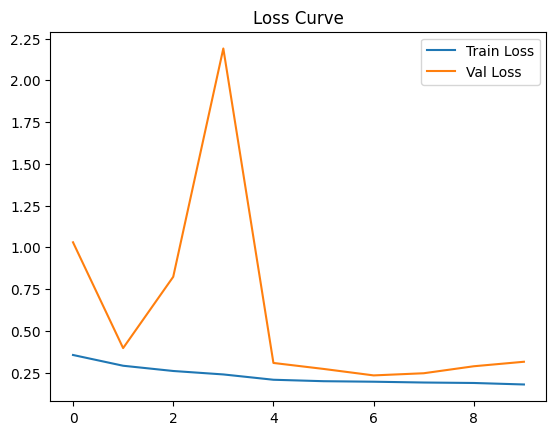

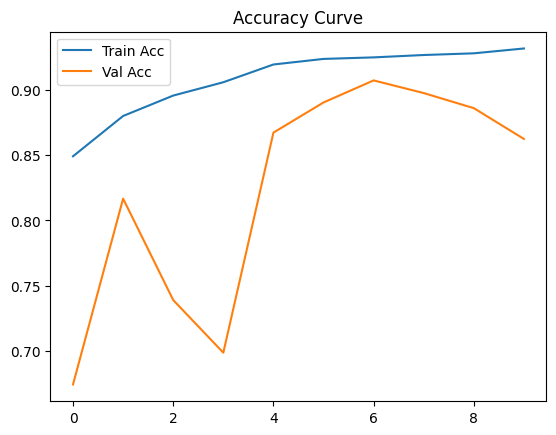

688/688 [==============================] - 46s 66ms/step


In [10]:
#history = history
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()



y_pred = model.predict(valid_ds)
  

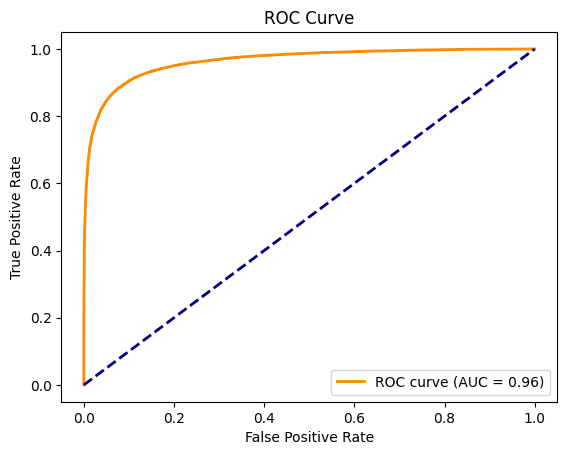

Best threshold: 0.47817102
Accuracy: 0.907283263265538
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     26182
           1       0.89      0.88      0.89     17823

    accuracy                           0.91     44005
   macro avg       0.90      0.90      0.90     44005
weighted avg       0.91      0.91      0.91     44005

688/688 [==============================] - 45s 66ms/step - loss: 0.2332 - accuracy: 0.9074
Validation Loss: 0.2332238107919693, Validation Accuracy: 0.9074196219444275


In [11]:
y_true = np.concatenate([y for x, y in valid_ds], axis=0)


fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
#fpr, tpr, thresholds = roc_curve(y_true, y_pred)
j_scores = tpr - fpr   
best_threshold = thresholds[j_scores.argmax()]
print("Best threshold:", best_threshold)
y_pred_classes = (y_pred > best_threshold).astype("int32")

print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))
loss, acc = model.evaluate(valid_ds)
print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

conclusion:<br>
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? <br>
As shown in the training curve plot, the model transitions from underfitting to overfitting. Based on the Kaggle score, the model lacks strong generalization. I believe there are two main reasons for this. First, my model consists of only three layers, which may not be deep enough to capture the complex features in the images. Many high-performing Kaggle models use pretrained architectures, which are typically deeper and more expressive than mine. Second, I included a cell that displays five positive and five negative samples. If you rerun it, you'll notice that some negative samples show sparse healthy cells, which supports the idea that my model struggles to generalize well.
Techniques that helped improve performance include tuning the learning rate, applying image augmentation, incorporating residual blocks, and using L2 regularization. However, adding more layers is a double-edged sword—it improves training accuracy and reduces loss, but also increases the risk of overfitting. Similarly, misusing layers like SeparableConv2D can lead to underfitting.<br>
The first thing I plan to try is transfer learning. Whether it's adapting my current model or using a pretrained architecture from Kaggle, transfer learning consistently outperforms training a raw neural network from scratch.


In [12]:
samplepath = f"{path}sample_submission.csv"

testdf = pd.read_csv(samplepath)
print(testdf.shape)
test_ds = make_infer_dataset(testdf, testpath, batch_size=64)


probs = model.predict(test_ds.map(lambda x, *_: x), verbose=0).squeeze()
print("probs stats -> min:", probs.min(), "max:", probs.max(), "mean:", probs.mean())
print("first 20 probs:", probs[:20])


predtest = (probs >= 0.5).astype(int)
print("preds unique:", np.unique(predtest, return_counts=True))


(57458, 2)
probs stats -> min: 2.3758944e-06 max: 1.0 mean: 0.37454656
first 20 probs: [0.03317556 0.06170096 0.0095264  0.06035478 0.05847759 0.9066892
 0.46073198 0.95016986 0.03322257 0.0394448  0.7407353  0.0496599
 0.00747492 0.00434955 0.02017925 0.9891588  0.00943259 0.07622702
 0.04906188 0.98659503]
preds unique: (array([0, 1]), array([36933, 20525]))


In [13]:
y_pred_test = (predtest > 0.5).astype("int32")#best_threshold

#print("Accuracy:", accuracy_score(y_truetest, y_pred_test))
#print(classification_report(y_truetest, y_pred_test))
#loss, acc = model.evaluate(test_ds)
#print(f"Validation Loss: {loss}, Validation Accuracy: {acc}")

same model and same file, should change the file name every time.

In [ ]:
#######

In [14]:
testdf['label'] = y_pred_test
testdf.to_csv(f"{path}23.csv", index=False)
model.save("cnn approach 23.h5") 

/opt/homebrew/anaconda3/envs/tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
